In [1]:
# Imports
import numpy as np
from Utils.GraphNetworkVisualizer import GraphNetworkVisualizer
from Utils.JsonModelParser import JsonModelParser

In [2]:
class ActivationFunction:
    def linear(self, x):
      return x

    def softmax(self, x):
        expX = np.exp(x - np.max(x, axis=1, keepdims=True))
        return expX / np.sum(expX, axis=1, keepdims=True)

    def relu(self, x):
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [3]:
class FastFeedNeuralNetwork:
    def __init__(self, layers, weights, input_data):
        self.input_data = np.array(input_data) if not isinstance(input_data, np.ndarray) else input_data
        self.layers = layers
        self.weights = [np.array(w) for w in weights]
        self.graph_visualizer = GraphNetworkVisualizer(layers, weights, input_data)

    def prepend_bias(self, activations):
        return np.insert(activations, 0, 1, axis=1)

    
    def predict(self):
        activations = self.input_data
        activationFunc = ActivationFunction()

        for i in range(len(self.layers)):
            activations_with_bias = self.prepend_bias(activations)
            net_input = np.dot(activations_with_bias, self.weights[i])

            # print("Activations:", activations)
            # print("Weights:", self.weights[i])
            # print("Net Input:", net_input)

            # Update nilai activations dengan menggunakan fungsi aktivasi yang diinginkan
            activation_function_str = self.layers[i]['activation_function']
            match activation_function_str:
                case "relu":
                    activations = activationFunc.relu(net_input)
                case "softmax":
                    activations = activationFunc.softmax(net_input)
                case "sigmoid":
                    activations = activationFunc.sigmoid(net_input)
                case "linear":
                    activations = activationFunc.linear(net_input)

            # print("Updated activations:", activations)

        return activations

Output: [[0.7042294 0.2957706]]
Sum of Squared Errors (SSE): 1.942281739821482e-19


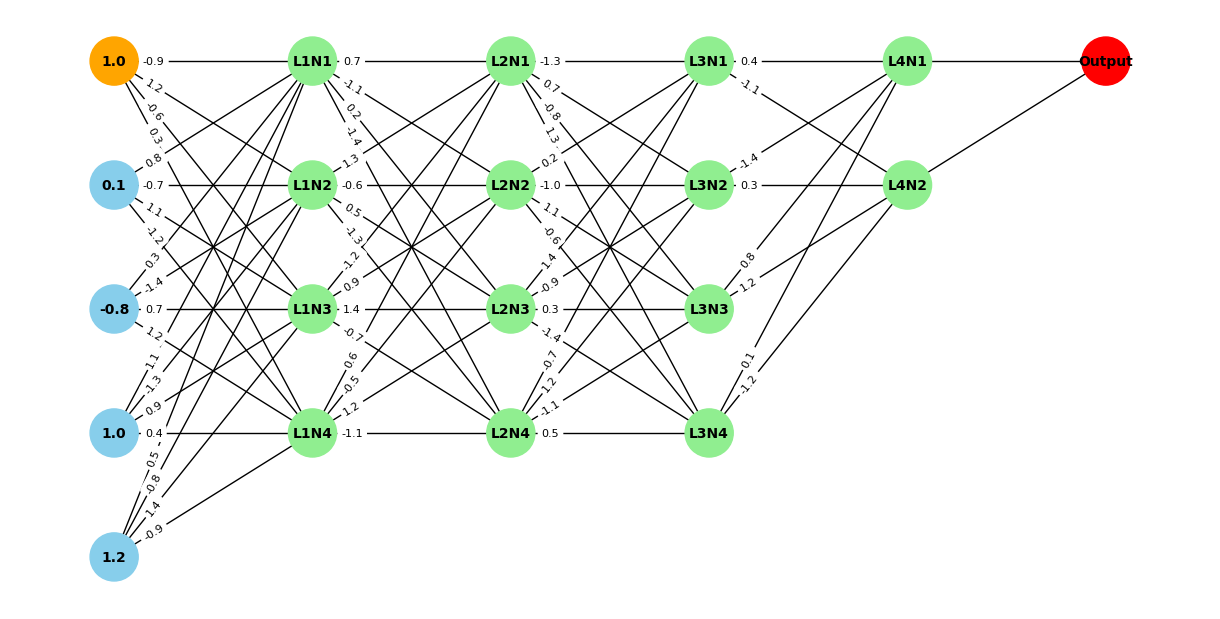

In [5]:
def main():
    # json_path = "Tests/" + input("Input json file name (*.json in Tests folder): ")
    json_path = 'Tests/multilayer_softmax.json'
    parser = JsonModelParser(json_path)
    if parser.data is None:
        print("Failed to load or parse the JSON data.")
    
    ffnn = FastFeedNeuralNetwork(parser.layers, parser.weights, parser.input_data)
    output = ffnn.predict()
    print("Output:", output)
    sse = np.sum((np.array(parser.output) - output) ** 2)
    print("Sum of Squared Errors (SSE):", sse)

    # Prints the graph
    ffnn.graph_visualizer.visualize()

if __name__ == '__main__':
    main()